This notebook mostly follows https://towardsdatascience.com/how-to-train-a-bert-model-from-scratch-72cfce554fc6 for Ukrainian

### Load pre-trained tokenizer and model

In [1]:
# load the pre-trained tokenizer
from transformers import RobertaTokenizer
tokenizer = RobertaTokenizer.from_pretrained('panas1', max_len=512)

# load the pre-trained model
from transformers import RobertaForMaskedLM
model = RobertaForMaskedLM.from_pretrained('./panas1')

import torch
from tqdm.auto import tqdm
from pathlib import Path
paths = [str(x) for x in Path('./data/text/oscar_uk').glob('**/*.txt')]

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        # store encodings internally
        self.encodings = encodings

    def __len__(self):
        # return the number of samples
        return self.encodings['input_ids'].shape[0]

    def __getitem__(self, i):
        # return dictionary of input_ids, attention_mask, and labels for index i
        return {key: tensor[i] for key, tensor in self.encodings.items()}

### Get the data

In [2]:
# get training data:
with open('./data/text/oscar_uk/text_5.txt', 'r', encoding='utf-8') as fp:
    lines = fp.read().split('\n')
batch = tokenizer(lines, max_length=512, padding='max_length', truncation=True)
labels = torch.tensor([x for x in batch['input_ids']])
mask = torch.tensor([x for x in batch['attention_mask']])
input_ids = labels.detach().clone()
rand = torch.rand(input_ids.shape)
mask_arr = (rand < .15) * (input_ids != 0) * (input_ids != 1) * (input_ids != 2)
for i in range(input_ids.shape[0]):
    # get indices of mask positions from mask array
    selection = torch.flatten(mask_arr[i].nonzero()).tolist()
    # mask input_ids
    input_ids[i, selection] = 3  # our custom [MASK] token == 3
encodings = {'input_ids': input_ids, 'attention_mask': mask, 'labels': labels}
dataset = Dataset(encodings)

In [3]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
#loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)
loader = DataLoader(dataset, sampler = RandomSampler(dataset), batch_size=4)

In [4]:
# get validation data
with open('./data/text/oscar_uk/text_1556.txt', 'r', encoding='utf-8') as fp:
    lines = fp.read().split('\n')

batch = tokenizer(lines, max_length=512, padding='max_length', truncation=True)
labels = torch.tensor([x for x in batch['input_ids']])
mask = torch.tensor([x for x in batch['attention_mask']])
input_ids = labels.detach().clone()
rand = torch.rand(input_ids.shape)
mask_arr = (rand < .15) * (input_ids != 0) * (input_ids != 1) * (input_ids != 2)
for i in range(input_ids.shape[0]):
    # get indices of mask positions from mask array
    selection = torch.flatten(mask_arr[i].nonzero()).tolist()
    # mask input_ids
    input_ids[i, selection] = 3  # our custom [MASK] token == 3

valencodings = {'input_ids': input_ids, 'attention_mask': mask, 'labels': labels}
valdataset = Dataset(valencodings)

In [5]:
# valloader = torch.utils.data.DataLoader(valdataset, batch_size=1, shuffle=True)
valloader = DataLoader(valdataset, sampler = SequentialSampler(valdataset), batch_size=4)

### Train the model

In [6]:
torch.cuda.empty_cache()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

RobertaForMaskedLM(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNor

In [7]:
from transformers import AdamW

# activate training mode
model.train()
# initialize optimizer
optim = AdamW(model.parameters(), lr=1e-5) 

In [11]:
import numpy as np
epochs = 4
loss_hist = [] # per iter
best_model = None
best_val_loss = np.Inf
val_loss_hist = [] # per iter

In [9]:
tr_losses = [] # per epoch
vl_losses = [] # per epoch

In [12]:
for epoch in range(epochs):
    # setup loop with TQDM and dataloader
    loop = tqdm(loader, leave=True)
    total_train_loss = 0 #####################
    model.train()        ######################
    for batch in loop:
        # initialize calculated gradients (from prev step)
        model.zero_grad() ###################
        # pull all tensor batches required for training
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        # process
        outputs = model(input_ids, attention_mask=attention_mask,
                        labels=labels)
        # extract loss
        loss = outputs.loss
        loss_hist.append(loss)
        total_train_loss += loss.item() ################
        # calculate loss for every parameter that needs grad update
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) ###################
        # update parameters
        optim.step()
        # print relevant info to progress bar
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())
    avg_train_loss = total_train_loss / len(loader) # train data loader ############
    tr_losses.append(avg_train_loss)
    
    # validation
    model.eval()

    # Tracking variables    
    total_eval_loss = 0
    nb_eval_steps = 0
    
    valloop = tqdm(valloader, leave=True)
    for valbatch in valloop:
        valinput_ids = valbatch['input_ids'].to(device)
        valattention_mask = valbatch['attention_mask'].to(device)
        vallabels = valbatch['labels'].to(device)
        with torch.no_grad():
            valoutputs = model(valinput_ids, attention_mask=valattention_mask,
                        labels=vallabels)
            valloss = valoutputs.loss
            val_loss_hist.append(valloss)
            total_eval_loss += loss.item()
    avg_val_loss = total_eval_loss / len(valloader)
    vl_losses.append(avg_val_loss)

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

  0%|          | 0/594 [00:00<?, ?it/s]

In [13]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

tensor(0.0582, device='cuda:0', grad_fn=<NllLossBackward>)


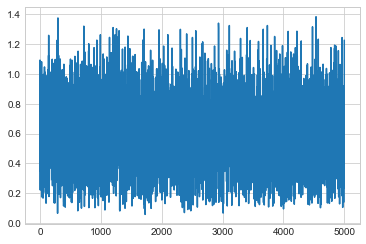

In [14]:
print(min(loss_hist))
losses = [x.to('cpu').detach().numpy() for x in loss_hist]
plt.plot(losses)

In [15]:
min(val_loss_hist)

tensor(0.0962, device='cuda:0')

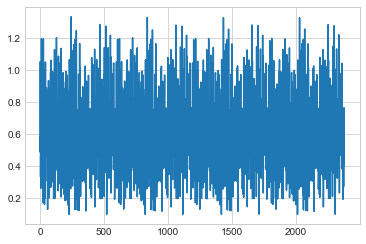

In [16]:
val_losses = [x.to('cpu').detach().numpy() for x in val_loss_hist]
plt.plot(val_losses)

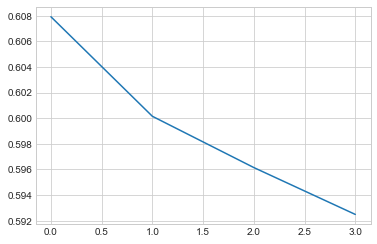

In [17]:
plt.plot(tr_losses)

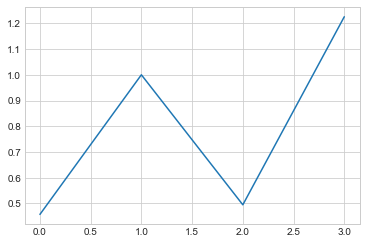

In [18]:
plt.plot(vl_losses)

The training loss seems to very slowly go down. The validation loss oscillates between 0.5 and 1 - like mad. The model doen't train...

### Test time

In [19]:
from transformers import pipeline

unmasker = pipeline("fill-mask", model=model.to('cpu'), tokenizer=tokenizer)

C:\Users\Asus\anaconda3\envs\torch\lib\site-packages\torchaudio\backend\utils.py:67: UserWarning: No audio backend is available.
  warnings.warn('No audio backend is available.')


In [20]:
# could you plpease tell me where is...?
unmasker(f'Скажіть, будь ласка, де  {unmasker.tokenizer.mask_token}?')

[{'sequence': 'Скажіть, будь ласка, де?',
  'score': 0.7749190330505371,
  'token': 4,
  'token_str': '<mask>'},
 {'sequence': 'Скажіть, будь ласка, де дочки?',
  'score': 0.00014321312482934445,
  'token': 23519,
  'token_str': ' дочки'},
 {'sequence': 'Скажіть, будь ласка, де Миргород?',
  'score': 0.000127349907415919,
  'token': 19503,
  'token_str': ' Миргород'},
 {'sequence': 'Скажіть, будь ласка, деуправ?',
  'score': 0.00012594512372743338,
  'token': 18658,
  'token_str': 'управ'},
 {'sequence': 'Скажіть, будь ласка, децип?',
  'score': 0.00011946725135203451,
  'token': 1892,
  'token_str': 'цип'}]

'Скажіть, будь ласка, де дочки?' makes sense. All the rest is rubbish

In [21]:
# How old are you?
# Скільки тобі років?
unmasker(f'Скільки тобі {unmasker.tokenizer.mask_token}?')

[{'sequence': 'Скільки тобі?',
  'score': 0.7047585248947144,
  'token': 4,
  'token_str': '<mask>'},
 {'sequence': 'Скільки тобі розпов?',
  'score': 0.00019022943160962313,
  'token': 3498,
  'token_str': ' розпов'},
 {'sequence': 'Скільки тобі Миргород?',
  'score': 0.00017983117140829563,
  'token': 19503,
  'token_str': ' Миргород'},
 {'sequence': 'Скільки тобіцип?',
  'score': 0.00013609511370304972,
  'token': 1892,
  'token_str': 'цип'},
 {'sequence': 'Скільки тобі情?',
  'score': 0.00012149316899012774,
  'token': 12169,
  'token_str': '情'}]

Nothing useful. It even got a Japanese kanji somewhere...

In [22]:
# I am thirsty
# Я хочу пити
unmasker(f'Я хочу {unmasker.tokenizer.mask_token}.')

[{'sequence': 'Я хочу.',
  'score': 0.6961378455162048,
  'token': 4,
  'token_str': '<mask>'},
 {'sequence': 'Я хочу розпов.',
  'score': 0.00013790720549877733,
  'token': 3498,
  'token_str': ' розпов'},
 {'sequence': 'Я хочуure.',
  'score': 0.00013763390597887337,
  'token': 5084,
  'token_str': 'ure'},
 {'sequence': 'Я хочу запорож.',
  'score': 0.00013751609367318451,
  'token': 28432,
  'token_str': ' запорож'},
 {'sequence': 'Я хочуасти.',
  'score': 0.00012212763249408454,
  'token': 27558,
  'token_str': 'асти'}]

Rubbish

In [23]:
# I am thirsty
# Я хочу пити
unmasker(f'{unmasker.tokenizer.mask_token} хочу пити.')

[{'sequence': ' хочу пити.',
  'score': 0.43019357323646545,
  'token': 4,
  'token_str': '<mask>'},
 {'sequence': ' казки хочу пити.',
  'score': 0.00032839810592122376,
  'token': 16167,
  'token_str': ' казки'},
 {'sequence': ' виконавці хочу пити.',
  'score': 0.00025981722865253687,
  'token': 29205,
  'token_str': ' виконавці'},
 {'sequence': ' запорож хочу пити.',
  'score': 0.00023996808158699423,
  'token': 28432,
  'token_str': ' запорож'},
 {'sequence': ' Миргород хочу пити.',
  'score': 0.0002329059934709221,
  'token': 19503,
  'token_str': ' Миргород'}]

Rubbish again

In [24]:
# Speak slower please
# Говоріть повільніше, будь ласка
unmasker(f'{unmasker.tokenizer.mask_token} повільніше, будь ласка.')

[{'sequence': ' повільніше, будь ласка.',
  'score': 0.5522949695587158,
  'token': 4,
  'token_str': '<mask>'},
 {'sequence': ' Всього повільніше, будь ласка.',
  'score': 0.0002453599008731544,
  'token': 13600,
  'token_str': ' Всього'},
 {'sequence': ' запорож повільніше, будь ласка.',
  'score': 0.00023034299374558032,
  'token': 28432,
  'token_str': ' запорож'},
 {'sequence': 'Відбу повільніше, будь ласка.',
  'score': 0.0002176444249926135,
  'token': 23635,
  'token_str': 'Відбу'},
 {'sequence': ' Миргород повільніше, будь ласка.',
  'score': 0.00021698330237995833,
  'token': 19503,
  'token_str': ' Миргород'}]

In [25]:
# How much is this?
# Скільки це коштує?
unmasker(f'Скільки це {unmasker.tokenizer.mask_token} ?')

[{'sequence': 'Скільки це?',
  'score': 0.707546591758728,
  'token': 4,
  'token_str': '<mask>'},
 {'sequence': 'Скільки це розпов?',
  'score': 0.00018940145673695952,
  'token': 3498,
  'token_str': ' розпов'},
 {'sequence': 'Скільки це Миргород?',
  'score': 0.00018089245713781565,
  'token': 19503,
  'token_str': ' Миргород'},
 {'sequence': 'Скільки цецип?',
  'score': 0.0001479090133216232,
  'token': 1892,
  'token_str': 'цип'},
 {'sequence': 'Скільки це дочки?',
  'score': 0.00014013497275300324,
  'token': 23519,
  'token_str': ' дочки'}]

In [26]:
# Bye!
# До побачення!
unmasker(f'{unmasker.tokenizer.mask_token} побачення!')

[{'sequence': ' побачення!',
  'score': 0.48383525013923645,
  'token': 4,
  'token_str': '<mask>'},
 {'sequence': ' комітетів побачення!',
  'score': 0.0003013308742083609,
  'token': 21717,
  'token_str': ' комітетів'},
 {'sequence': '2008 побачення!',
  'score': 0.0002784871612675488,
  'token': 8542,
  'token_str': '2008'},
 {'sequence': ' Миргород побачення!',
  'score': 0.00023597262043040246,
  'token': 19503,
  'token_str': ' Миргород'},
 {'sequence': ' казки побачення!',
  'score': 0.00022960154456086457,
  'token': 16167,
  'token_str': ' казки'}]

Nonsense